In [24]:
# import numpy as np
# np.random.seed(1)
# pKeep = 0.8
# weights = np.ones([1, 5])
# binary_value = np.random.rand(weights.shape[0], weights.shape[1]) < pKeep
# res = np.multiply(weights, binary_value)
# res /= pKeep  # this line is called inverted dropout technique
# print(res)
# print(binary_value)

[[1.25 1.25 1.25 1.25 1.25]]
[[ True  True  True  True  True]]


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# Normalize the data.
from sklearn import preprocessing
from sklearn.model_selection import KFold

# Reproducable results
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    import random
    random.seed(seed)

Define functions to normalize and de-normalize the data

In [30]:
# Load labeled data
data = np.loadtxt('C:/Users/berkc/git/Physics-Informed-Machine-Learning/data/labeled_data.dat')

x_exp = data[:, :2]
y_exp = data[:, -2]
y_exp = y_exp[:, np.newaxis]

Load the data by calling the function we defined above:

In [31]:
# normalize dataset with MinMaxScaler
scaler1 = preprocessing.MinMaxScaler(feature_range=(0, 1.0))
scaler2 = preprocessing.MinMaxScaler(feature_range=(0, 1.0))
inp = scaler1.fit_transform(x_exp)
out = scaler2.fit_transform(y_exp)

# scaler = preprocessing.StandardScaler()
# inp = scaler.fit_transform(x_exp)
# out = scaler.fit_transform(y_exp)

# stack input and output data
data = np.column_stack((inp,out))

batch_size = 5

Define functions and classes for the BNN:

In [32]:
def to_variable(var=(), cuda=False, volatile=False):
    out = []
    for v in var:

        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)

        # if not v.is_cuda and cuda:
        #     v = v.cuda()

        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)

        out.append(v)
    return out

# def log_gaussian_loss(output, target, sigma, no_dim):
#     exponent = -0.5 * (target - output) ** 2 / sigma ** 2
#     log_coeff = -no_dim * torch.log(sigma) - 0.5 * no_dim * np.log(2 * np.pi)
#     return - (log_coeff + exponent).sum()



class MC_Dropout_Model(nn.Module):
    def __init__(self, input_dim, output_dim, num_units, drop_prob):
        super(MC_Dropout_Model, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.drop_prob = drop_prob

        # network with two hidden and one output layer
        self.layer1 = nn.Linear(input_dim, num_units)
        self.layer2 = nn.Linear(num_units, num_units)
        # self.layer3 = nn.Linear(num_units, num_units)
        # self.layer4 = nn.Linear(num_units, num_units)
        self.layer3 = nn.Linear(num_units, output_dim)

        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = x.view(-1, self.input_dim)

        x = self.layer1(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True)

        x = self.layer2(x)
        x = self.activation(x)
        x = F.dropout(x, p=self.drop_prob, training=True)
        
        # x = self.layer3(x)
        # x = self.activation(x)
        # x = F.dropout(x, p=self.drop_prob, training=True)
        #
        # x = self.layer4(x)
        # x = self.activation(x)
        # x = F.dropout(x, p=self.drop_prob, training=True)

        x = self.layer3(x)

        return x


class MC_Dropout_Wrapper:
    def __init__(self, network, learn_rate, batch_size, weight_decay):
        self.learn_rate = learn_rate
        self.batch_size = batch_size

        self.network = network
        # self.network.cuda()

#         self.optimizer = torch.optim.SGD(self.network.parameters(), lr=learn_rate, weight_decay=weight_decay)
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=learn_rate, weight_decay=weight_decay)
        self.loss_func = nn.MSELoss()

    def fit(self, x, y):
        x, y = to_variable(var=(x, y), cuda=True)

        # reset gradient and total loss
        self.optimizer.zero_grad()

        output = self.network(x)
        loss = self.loss_func(output, y)
#         loss = self.loss_func(output[:, :1], y, output[:, 1:].exp(), 1)

        loss.backward()
        self.optimizer.step()

        return loss

    def get_loss_and_rmse(self, x, y, num_samples):
        x, y = to_variable(var=(x, y), cuda=True)

        means, stds = [], []
        for i in range(num_samples):
            output = self.network(x)
            means.append(output)
#             stds.append(output[:, 1:].exp())

        means = torch.cat(means, dim=1)
        mean = means.mean(dim=-1)[:, None]
#         std = ((means.var(dim=-1) + stds.mean(dim=-1) ** 2) ** 0.5)[:, None]
        loss = self.loss_func(mean, y)

        rmse = ((mean - y) ** 2).mean() ** 0.5
#         rmse = torch.sqrt(torch.mean((mean - y).pow(2)))

        return loss.detach().cpu(), rmse.detach().cpu()


Define the function that fits the BNN and shuffles the data and use some for testing.

In [33]:
def train_mc_dropout(data, drop_prob, ratio_train_data, num_epochs, num_units, learn_rate, weight_decay, log_every,
                     num_samples):

    in_dim = data.shape[1] - 1
    train_logliks, test_logliks = [], []
    train_rmses, test_rmses = [], []

    history_loss, history_loss_test, history_rmse, history_rmse_test = [], [], [], []

    # -------------------------------------------------------------------------
    #               Random Permutation of Training Data
    # -------------------------------------------------------------------------
    nl = data.shape[0]  # size of training data

    # randomly select RatioToBeUsed to be training set for GP model
    num_train = round(ratio_train_data * nl)
#     idx_ = np.random.permutation(nl)
    idx_ = np.arange(nl)  # do not do random permutation

    # Use the first RatioToBeUsed to train the model
    idx_train = idx_[0:num_train]

    x_train, y_train = data[idx_train, :in_dim], data[idx_train, in_dim:]

    # The (1-RatioToBeUsed) will be used to test the model
    idx_test = idx_[(num_train + 1):]
    x_test, y_test = data[idx_test, :in_dim], data[idx_test, in_dim:]

    y_means, y_stds = y_train.mean(axis=0), y_train.var(axis=0) ** 0.5

    net = MC_Dropout_Wrapper(
            network=MC_Dropout_Model(input_dim=in_dim, output_dim=1, num_units=num_units, drop_prob=drop_prob),
            learn_rate=learn_rate, batch_size=batch_size, weight_decay=weight_decay)

    for i in range(num_epochs):

        loss = net.fit(x_train, y_train)

        tt, rmse_train = net.get_loss_and_rmse(x_train, y_train, num_samples=num_samples)
        rmse_train = rmse_train.cpu().data.numpy()

        test_loss, rmse_test = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)
        test_loss, rmse_test = test_loss.cpu().data.numpy(), rmse_test.cpu().data.numpy()

#         history_loss.append(loss.cpu().data.numpy() / len(x_train))
#         history_loss_test.append(test_loss / len(x_test))
        history_loss.append(loss.cpu().data.numpy() )
        history_loss_test.append(test_loss )
        history_rmse.append(rmse_train )
        history_rmse_test.append(rmse_test )

        if i % log_every == 0 or i == num_epochs - 1:
            test_loss, rmse = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)
            test_loss, rmse = test_loss.cpu().data.numpy(), rmse.cpu().data.numpy()

            print('Epoch: %4d, Train loss: %6.3f Test loss: %6.3f RMSE: %.3f' %
                  (i, loss.cpu().data.numpy(), test_loss, rmse ))
#                     (i, loss.cpu().data.numpy() / len(x_train), test_loss / len(x_test), rmse ))

    train_loss, train_rmse = net.get_loss_and_rmse(x_train, y_train, num_samples=num_samples)
    test_loss, test_rmse = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)

    train_logliks.append((train_loss.cpu().data.numpy() / len(x_train) + np.log(y_stds)[0]))
    test_logliks.append((test_loss.cpu().data.numpy() / len(x_test) + np.log(y_stds)[0]))

    train_rmses.append(train_rmse.cpu().data.numpy())
    test_rmses.append(test_rmse.cpu().data.numpy())

    plt.figure()
    # plot history of accuracy
    # Plot training & validation accuracy values
    plt.plot(history_rmse)
    plt.plot(history_rmse_test)
    plt.title('Model accuracy')
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    plt.figure()
    # Plot training & validation loss values
    plt.plot(history_loss)
    plt.plot(history_loss_test)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    print('Train log. lik. = %6.3f +/- %6.3f' % (-np.array(train_logliks).mean(), np.array(train_logliks).var() ** 0.5))
    print('Test  log. lik. = %6.3f +/- %6.3f' % (-np.array(test_logliks).mean(), np.array(test_logliks).var() ** 0.5))
    print('Train RMSE      = %6.3f +/- %6.3f' % (np.array(train_rmses).mean(), np.array(train_rmses).var() ** 0.5))
    print('Test  RMSE      = %6.3f +/- %6.3f' % (np.array(test_rmses).mean(), np.array(test_rmses).var() ** 0.5))

    return net, x_test, y_test

In [39]:
def train_mc_dropout_Kfold(data, drop_prob, n_splits, num_epochs, num_units, learn_rate, weight_decay, log_every,
                           num_samples, plot_history=False):
    
    kf = KFold(n_splits=n_splits, shuffle=False)
    in_dim = data.shape[1] - 1
    train_logliks, test_logliks = [], []
    train_rmses, test_rmses = [], []

    if plot_history == True:
        avg_history_loss, avg_history_loss_test, avg_history_rmse, avg_history_rmse_test = [], [], [], []

    # # random shuffle data
    # np.random.shuffle(data)

    for j, idx in enumerate(kf.split(data)):
        
        if plot_history == True:
            history_loss, history_loss_test, history_rmse, history_rmse_test = [], [], [], []
        
        print('FOLD %d:' % j)
        
        train_index, test_index = idx

        x_train, y_train = data[train_index, :in_dim], data[train_index, in_dim:]
        x_test, y_test = data[test_index, :in_dim], data[test_index, in_dim:]
        print(x_train.shape, x_test.shape)

        # x_means, x_stds = x_train.mean(axis=0), x_train.var(axis=0) ** 0.5
        # y_means, y_stds = y_train.mean(axis=0), y_train.var(axis=0) ** 0.5

        net = MC_Dropout_Wrapper(
            network=MC_Dropout_Model(input_dim=in_dim, output_dim=1, num_units=num_units, drop_prob=drop_prob),
            learn_rate=learn_rate, batch_size=batch_size, weight_decay=weight_decay)

        # losses = []
        # fit_loss_train = np.zeros(num_epochs)

        for i in range(num_epochs):
            loss = net.fit(x_train, y_train)

            if plot_history == True:
                # to save loss & rmse at every epoch
                train_loss, rmse_train = net.get_loss_and_rmse(x_train, y_train, num_samples=num_samples)
                rmse_train = rmse_train.cpu().data.numpy()

                test_loss, rmse_test = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)
                test_loss, rmse_test = test_loss.cpu().data.numpy(), rmse_test.cpu().data.numpy()

#                 history_loss.append(loss.cpu().data.numpy() / len(x_train))
#                 history_loss_test.append(test_loss / len(x_test))
                history_loss.append(loss.cpu().data.numpy() )
                history_loss_test.append(test_loss )
                history_rmse.append(rmse_train)
                history_rmse_test.append(rmse_test)

            if i % log_every == 0 or i == num_epochs - 1:
                train_loss, train_rmse = net.get_loss_and_rmse(x_train, y_train, num_samples=num_samples)
                train_loss, train_rmse = train_loss.cpu().data.numpy(), train_rmse.cpu().data.numpy()

                test_loss, test_rmse = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)
                test_loss, test_rmse = test_loss.cpu().data.numpy(), test_rmse.cpu().data.numpy()


                print('Epoch: %4d, Train loss: %6.5f Test loss: %6.5f Train RMSE: %.5f Test RMSE: %.5f' %
                      (i, loss.cpu().data.numpy(), test_loss, train_rmse, test_rmse))
        if plot_history == True:
            avg_history_loss.append(history_loss)
            avg_history_loss_test.append(history_loss_test)
            avg_history_rmse.append(history_rmse)
            avg_history_rmse_test.append(history_rmse_test)

        train_loss, train_rmse = net.get_loss_and_rmse(x_train, y_train, num_samples=num_samples)
        test_loss, test_rmse = net.get_loss_and_rmse(x_test, y_test, num_samples=num_samples)

        train_logliks.append(train_loss.cpu().data.numpy() / len(x_train) )
        test_logliks.append(test_loss.cpu().data.numpy() / len(x_test) )

        train_rmses.append(train_rmse.cpu().data.numpy())
        test_rmses.append(test_rmse.cpu().data.numpy())

    if plot_history == True:
        # Save plots
        legends = ['Train', 'Test']
        format = True  # true for pdf, false for pgf
        file_name1 = 'Epoch_vs_Loss'
        file_name2 = 'Epoch_vs_RMSE'

        avg_history_loss = np.array(avg_history_loss).mean(axis=0)
        avg_history_loss_test = np.array(avg_history_loss_test).mean(axis=0)
        avg_history_rmse = np.array(avg_history_rmse).mean(axis=0)
        avg_history_rmse_test = np.array(avg_history_rmse_test).mean(axis=0)

        labels = ['Epoch', 'Loss']

        x1, y1 = list(range(1, avg_history_loss.shape[0]+1)), avg_history_loss
        x2, y2 = list(range(1, avg_history_loss_test.shape[0] + 1)), avg_history_loss_test
        sF.save_plot(x1, y1, labels, legends, format, file_name1, x2, y2)

        x3, y3 = list(range(1, avg_history_rmse.shape[0] + 1)), avg_history_rmse
        x4, y4 = list(range(1, avg_history_rmse_test.shape[0] + 1)), avg_history_rmse_test
        sF.save_plot(x3, y3, labels, legends, format, file_name2, x4, y4)
        
    print('Train log. lik. = %6.5f +/- %6.5f' % (-np.array(train_logliks).mean(), np.array(train_logliks).var() ** 0.5))
    print('Test  log. lik. = %6.5f +/- %6.5f' % (-np.array(test_logliks).mean(), np.array(test_logliks).var() ** 0.5))
    print('Train RMSE      = %6.5f +/- %6.5f' % (np.array(train_rmses).mean(), np.array(train_rmses).var() ** 0.5))
    print('Test  RMSE      = %6.5f +/- %6.5f' % (np.array(test_rmses).mean(), np.array(test_rmses).var() ** 0.5))

    return net, x_test, y_test

Call the function to build the network

In [46]:
seed = 1
set_seed(seed)

nobs = 35

# Parameters
wght_decay, p_drop, learn_rate = 1e-3, 0.1, 5e-3
train_data_ratio, nb_units, nb_epochs = nobs/data.shape[0], 5, 400

# net, x_tst, y_tst = train_mc_dropout(data=data, drop_prob=p_drop, num_epochs=nb_epochs, 
#                                      ratio_train_data=train_data_ratio, num_units=nb_units, learn_rate=learn_rate, 
#                                      weight_decay=wght_decay, num_samples=2, log_every=100)


plot_history = False # plot loss and rmse vs epochs if True
data_train = data[:nobs,:]

# Build the network, K-fold
net, x_tst, y_tst = train_mc_dropout_Kfold(data=data_train, drop_prob=p_drop, num_epochs=nb_epochs,
                                           n_splits=3, num_units=nb_units,
                                           learn_rate=learn_rate,
                                           weight_decay=wght_decay, num_samples=10, log_every=100, plot_history=plot_history)

FOLD 0:
(23, 2) (12, 2)
Epoch:    0, Train loss: 0.41951 Test loss: 0.42471 Train RMSE: 0.64747 Test RMSE: 0.65170
Epoch:  100, Train loss: 0.03646 Test loss: 0.01789 Train RMSE: 0.14693 Test RMSE: 0.13376
Epoch:  200, Train loss: 0.03472 Test loss: 0.01066 Train RMSE: 0.09482 Test RMSE: 0.10325
Epoch:  300, Train loss: 0.01506 Test loss: 0.00564 Train RMSE: 0.08088 Test RMSE: 0.07507
Epoch:  399, Train loss: 0.01643 Test loss: 0.00761 Train RMSE: 0.08142 Test RMSE: 0.08726
FOLD 1:
(23, 2) (12, 2)
Epoch:    0, Train loss: 0.07681 Test loss: 0.13441 Train RMSE: 0.26696 Test RMSE: 0.36663
Epoch:  100, Train loss: 0.04924 Test loss: 0.10739 Train RMSE: 0.22564 Test RMSE: 0.32770
Epoch:  200, Train loss: 0.05112 Test loss: 0.10566 Train RMSE: 0.22600 Test RMSE: 0.32505
Epoch:  300, Train loss: 0.02889 Test loss: 0.04402 Train RMSE: 0.14071 Test RMSE: 0.20981
Epoch:  399, Train loss: 0.00747 Test loss: 0.02690 Train RMSE: 0.09058 Test RMSE: 0.16400
FOLD 2:
(24, 2) (11, 2)
Epoch:    0, Train

Test the model using the unique temperature values of the test data and plot the predictions with both epistemic and aleatoric uncertainty. The epistemic uncertainty is obtained by running the BNN (MC dropout) several times.

In [10]:
#--------------------------------------#
# sobol samples & candidate points
#--------------------------------------#
n = 100
d = x_exp.shape[1] # dimension of input

# intialise data of lists.
X1 = pd.DataFrame(np.random.uniform(0,1,size=(n,d)), columns=['X1', 'X2'])
X2 = pd.DataFrame(np.random.uniform(0,1,size=(n,d)), columns=['X1', 'X2'])
candidate = pd.DataFrame(np.random.uniform(0,1,size=(10,d)), columns=['X1', 'X2'])

In [11]:
X1_np = X1.to_numpy()
X2_np = X2.to_numpy()
candidate_np = candidate.to_numpy()
inp_sim = np.vstack((X1_np,X2_np,candidate_np))

In [48]:
# seed = 1
# set_seed(seed)

# Get a tuple of unique values & their first index location from a numpy array
uniqueValues, indicesList = np.unique(x_tst[:,0], return_index=True)
x_tst = x_tst[indicesList]

# Only use the selected unique test data
y_tst = y_tst[indicesList]

x_pred = torch.tensor(x_tst.astype(np.float32)) # convert to torch tensor
# x_pred = torch.tensor(inp_sim.astype(np.float32)) # convert to torch tensor

samples = []
noises = []
for i in range(10):
    preds = net.network.forward(x_pred).cpu().data.numpy()
    samples.append(preds[:,np.newaxis])
#     noises.append(preds[:,1][:,np.newaxis])

samples = np.array(samples)
samples = np.squeeze(samples)
noises = np.exp(noises)
means = (samples.mean(axis=0)).reshape(-1)

aleatoric = ((noises ** 2).mean(axis=0) ** 0.5).reshape(-1)
epistemic = (samples.var(axis=0) ** 0.5).reshape(-1)
total_unc = (aleatoric ** 2 + epistemic ** 2) ** 0.5

print("Aleatoric uncertainty mean: {0:.4f}, Epistemic uncertainty mean: {1:.4f}, Total uncertainty mean: {2:.4f}"
      .format(aleatoric.mean(), epistemic.mean(), total_unc.mean()))
print("Aleatoric uncertainty std: {0:.4f}, Epistemic uncertainty std: {1:.4f}, Total uncertainty std: {2:.4f}"
      .format(aleatoric.std(), epistemic.std(), total_unc.std()))

Aleatoric uncertainty mean: nan, Epistemic uncertainty mean: 0.0649, Total uncertainty mean: nan
Aleatoric uncertainty std: nan, Epistemic uncertainty std: 0.0445, Total uncertainty std: nan


C:\Users\berkc\Miniconda3\envs\pytR_BNN\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice.
C:\Users\berkc\Miniconda3\envs\pytR_BNN\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Plot predictions with predictive mean and variance

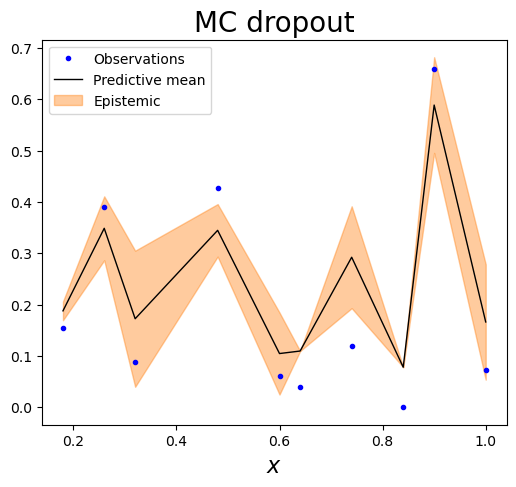

In [49]:
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

# denormalize test data
# x_tst = denormalize_max_min(x_tst, max_x, min_x)
# y_tst = denormalize_max_min(y_tst, max_y, min_y)

# PLOT FIGURES
plt.figure(figsize=(6, 5))
plt.style.use('default')
plt.plot(x_tst[:,0], y_tst, 'b.', label='Observations');
plt.fill_between(x_tst[:,0], means - total_unc, means - epistemic, color=c[0], alpha=0.3)
plt.fill_between(x_tst[:,0], means - epistemic, means + epistemic, color=c[1], alpha=0.4,
                 label='Epistemic')
plt.plot(x_tst[:,0], means, color='black', linewidth=1, label='Predictive mean')
plt.xlabel('$x$', fontsize=16)
plt.title('MC dropout', fontsize=20)
plt.legend()
plt.savefig('pred3.pdf')  
plt.show()